# __Behind the pipeline (PyTorch)__

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

## Так работает процедура в целом

In [2]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
# classifier = pipeline("sentiment-analysis", model = "distilbert/distilbert-base-uncased-finetuned-sst-2-english")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9598049521446228},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

## Что под "капотом"

### 1. Токенизация

Создаем токенизатор, которому сможем напрямую передавать предложения и получать словарь, готовый к отправке в модель!

In [3]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

С помощью него, мы преобразовываем наши СЫРЫЕ данные в тензоры.

Использую 🤗 Transformers, можно не беспокоиться о том, какой фреймворк ML используется в качестве бэкенда: PyTorch, TensorFlow или Flax для некоторых моделей. Однако модели Transformer принимают только тензоры в качестве входных данных.  

*Если вы впервые слышите о тензорах, вы можете думать о них как о массивах NumPy. Массив NumPy может быть скаляром (0D), вектором (1D), матрицей (2D) или иметь больше измерений. По сути, это тензор; тензоры других фреймворков ML ведут себя аналогично и обычно так же просты в создании, как и массивы NumPy.*

In [4]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

# padding=True - в более коротких предложениях недостающие (до длинны максимального предложения) токены приравниваются нулю,
# truncation=True - проедложения, превышающие ограничения по длине, обрезаются,
# return_tensors="pt" - указываем тип тензоров, которые мы хотим получить обратно (PyTorch, TensorFlow или простой NumPy)
# если тип не будет передан, вы получите список списков в качестве результата

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


Вывод представляет собой словарь, содержащий два ключа:  input_ids и awareness_mask.  
- `input_ids` - содержит две строки целых чисел (по одной для каждого предложения), которые являются уникальными идентификаторами токенов в каждом предложении.  
- `awareness_mask` -

### Прохождение модели  

Мы можем загрузить нашу предварительно обученную модель так же, как мы это делали с нашим токенизатором. 🤗 Transformers предоставляет класс AutoModel, который также имеет метод from_pretrained():

Это экземпляр модели.
Эта архитектура содержит только базовый модуль Transformer: при наличии некоторых входных данных он выводит то, что мы будем называть скрытыми состояниями, также известными как признаки. Для каждого входного значения модели мы извлечем многомерный вектор, представляющий контекстное понимание этого входного значения моделью Transformer.  
Хотя эти скрытые состояния могут быть полезны сами по себе, они обычно являются входными данными для другой части модели, известной как голова. Различные задачи могут быть выполнены с помощью той же архитектуры, но для иных задач нужна другая голова.

In [2]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [5]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 16, 768])


Выходной вектор модуля Transformer обычно большой. Обычно он имеет три измерения:  
- Размер пакета: количество последовательностей, обрабатываемых за один раз (в нашем примере 2).
- Длина последовательности: длина числового представления последовательности (в нашем примере 16).
- Скрытый размер: векторное измерение каждого входного сигнала модели.  

Он называется «многомерным» из-за последнего значения. Скрытый размер может быть очень большим (768 — обычное значение для небольших моделей, а в более крупных моделях он может достигать 3072 и более).

Выходные данные моделей 🤗 Transformers ведут себя как именованные кортежи или словари.   
Доступ к элементам
- по атрибутам (как мы) или
- по ключу (outputs["last_hidden_state"]), или даже
- по индексу, если вы точно знаете, где находится то, что вы ищете (outputs[0]).

In [ ]:
# outputs[0]
outputs["last_hidden_state"]

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
file_path = "/content/drive/My Drive/Hugging_face/6_Head.png"

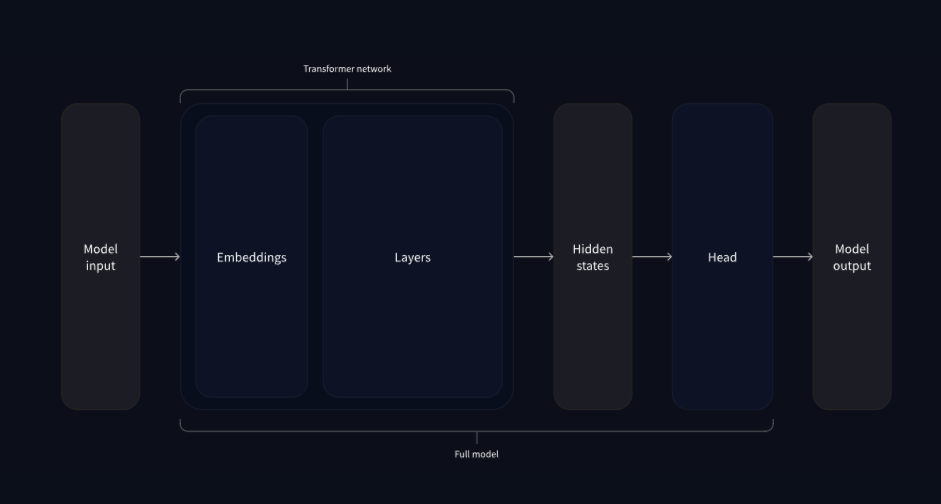

In [16]:
from IPython.display import display
from PIL import Image

# Открываем и отображаем изображение
img = Image.open(file_path)  # Укажите путь к файлу
display(img)

Модель представлена слоем внедрений и последующими слоями. Слой внедрений преобразует каждый входной идентификатор в токенизированном входе в вектор, который представляет связанный токен. Последующие слои манипулируют этими векторами, используя механизм внимания, чтобы создать окончательное представление предложений.

Нам нужна модель с последовательной классификацией (чтобы иметь возможность классифицировать предложения как положительные или отрицательные). Поэтому мы на самом деле не будем использовать класс AutoModel, а будем использовать AutoModelForSequenceClassification:

In [17]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

In [20]:
print(outputs.logits.shape)

torch.Size([2, 2])


Поскольку у нас всего два предложения и две метки, результат, который мы получаем с помощью нашей модели, имеет форму 2 x 2.

In [21]:
print(outputs.logits)

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)


Наша модель предсказала [-1,5607, 1,6123] для первого предложения и [4,1692, -3,3464] для второго. Это не вероятности, а логиты, сырые, ненормализованные оценки, выдаваемые последним слоем модели. Чтобы преобразовать их в вероятности, они должны пройти через слой SoftMax (все модели 🤗 Transformers выводят логиты, поскольку функция потерь для обучения обычно объединяет последнюю функцию активации, такую ​​как SoftMax, с фактической функцией потерь, такой как перекрестная энтропия):

In [22]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


In [23]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}